In [7]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt 
from numpy.linalg import eigvals
from scipy.optimize import minimize
from scipy.optimize import fsolve 

In [19]:
def first_eqs(t, b, m, s):
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m)
    b = float(b) 

    # clip exponent arguments to avoid overflow
    safe_clip = 700.0
    x = (9/4) * s / t
    y = b * m / t
    x = np.clip(x, -safe_clip, safe_clip)
    y = np.clip(y, -safe_clip, safe_clip) 

    exp = np.exp(x) 
    cosh = np.cosh(y) 

    denom = 2 + exp * cosh 
    denom = np.maximum(denom, 1e-300)

    # avoid division by zero
    if denom == 0:
        return 1e6

    return  s + 3 / denom - 1 


def second_eqs(t, b, m, s): 
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m)
    b = float(b) 

    safe_clip = 700.0
    x = (3/2) * s / t
    y = b * m / t 
    w = -(3/4) * s / t 
    x = np.clip(x, -safe_clip, safe_clip)
    y = np.clip(y, -safe_clip, safe_clip)
    w = np.clip(w, -safe_clip, safe_clip) 

    exp1 = np.exp(x) 
    exp2 = np.exp(w)
    cosh = np.cosh(y) 
    sinh = np.sinh(y)

    denom = 2 * exp2 + exp1 *cosh 
    denom = np.maximum(denom, 1e-300)

    return  b*m - b * exp1 * sinh / denom


def bound_equations(t, b, vars_): 
    m, s = vars_
    return [first_eqs(t, b, m, s) , second_eqs(t, b, m, s)]

def hessian(t, b, m, s): 
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m)
    b = float(b) 

    safe_clip = 700.0
    x = (9/4) * s / t
    y = b * m / t 
    x = np.clip(x, -safe_clip, safe_clip)
    y = np.clip(y, -safe_clip, safe_clip)


    #precompute recurring terms with safe clip
    exp = np.exp(x)
    cosh = np.cosh(y) 
    sinh = np.sinh(y) 

    #common denominators
    denom1 = (2 + exp*cosh)*(2 + exp*cosh)
    denom2 = 8*t + 4*exp*t*cosh 

    # guard denominators
    denom1 = np.maximum(denom1, 1e-300)
    denom2 = np.maximum(denom2, 1e-300)

    #individual Hessian elements 
    H11 = 1 + 9/(4*t*denom1) - 9/denom2
    H12 = 9/(4*t*denom1) 
    H13 = (9*exp*cosh)/(4*t*denom1) 
    H16 = (3*b*exp*sinh)/(2*t*denom1) 
    H33 = 1 + 9/(t*denom1) - 9/(4*t + 2*exp*t*cosh)
    H36 = -(3*b*exp*sinh)/(t*denom1) 
    H44 = b - b * b / (2*t + exp*t*cosh)
    H66 = b - b*b*exp*(exp + 2*cosh)/(t*denom1)

    # full Hessian matrix 
    hessian_matrix = np.array([
        [H11, H12, H13, 0.0, 0.0, H16],
        [H12, H11, H13, 0.0, 0.0, H16],
        [H13, H13, H33, 0.0, 0.0, H36],
        [0.0, 0.0, 0.0, H44, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, H44, 0.0],
        [H16, H16, H36, 0.0, 0.0, H66]
    ])

    # make symmetric
    hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)

    return hessian_matrix 

def stability_check(t, b, vars_, tol=-1e-9):
    m, s = vars_
    
    #return False (unstable / not defined) if any input is NaN or not finite
    if not (np.isfinite(t) and np.isfinite(m) and np.isfinite(s)):
        return False
    
    H = hessian(t, b, m, s)

    # check the matrix itself
    if not np.all(np.isfinite(H)):
        return False
    
    e = np.real_if_close(eigvals(H))
    
    # require all eigenvalues strictly greater than tol
    return np.all(e > tol)


In [ ]:
b = 0.5
t = 0.1
s_vals, m_vals = [], [] 

sol = root(lambda vars_: bound_equations(t, b, vars_), [s_vals[-1] if s_vals else 1.0, m_vals[-1] if m_vals else 1.0]) #vars_ = m, s
print(sol.x)
sol.success

[0.99990912 1.        ]


True

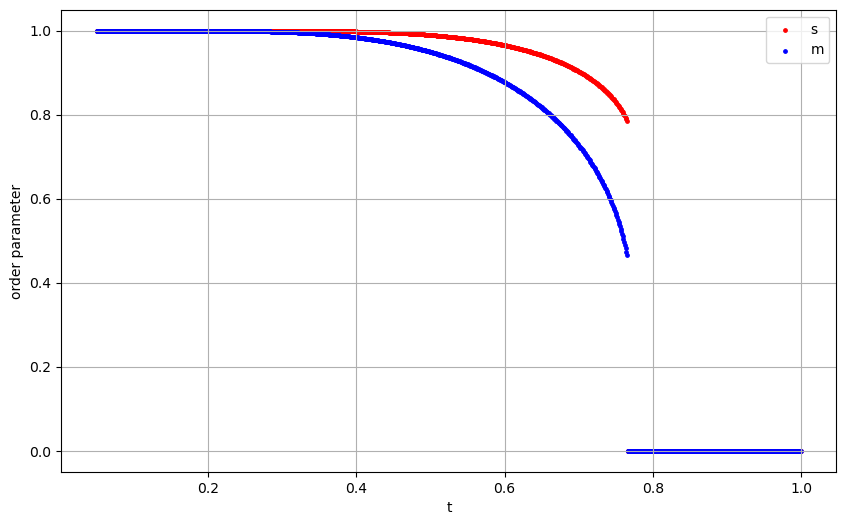

In [47]:
b = 1.0 #given value 
s_vals, m_vals = [], [] 

t_vals = np.linspace(0.05, 1.0, 1000) 

for t in t_vals: 
    sol = root(lambda vars_: bound_equations(t, b, vars_), [s_vals[-1] if s_vals else 1.0, m_vals[-1] if m_vals else 1.0]) #vars_: m, s 
    if sol.success: 
        m_vals.append(sol.x[0]) 
        s_vals.append(sol.x[1]) 
    else: 
        # Try fallback  
        sol = root(lambda vars_: bound_equations(t, b, vars_), [s_vals[-1] if s_vals else 1.0, m_vals[-1] if m_vals else 1.0], method = 'lm') 
        if sol.success: 
            m_vals.append(sol.x[0]) 
            s_vals.append(sol.x[1]) 
        else: 
            m_vals.append(np.nan) 
            s_vals.append(np.nan)   


t_stable, m_stable, s_stable = [],[],[] 
for i in range(len(t_vals)): 
    if stability_check(t_vals[i],b, [m_vals[i] , s_vals[i]]):
        m_stable.append(m_vals[i]) 
        s_stable.append(s_vals[i]) 
        t_stable.append(t_vals[i]) 

# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(t_stable, s_stable, label=f's', color='red',s=6)
plt.scatter(t_stable, m_stable, label=f'm', color='blue',s=6) 

plt.xlabel('t')
plt.ylabel('order parameter')
plt.legend()
plt.grid(True) 
plt.show() 


## Phase Diagram

In [52]:
b_sample = np.linspace(0.01, 1.0, 500)
n = len(b_sample) 
s_map = np.full((n, n), 0, dtype=float) 
m_map = np.full((n, n), 0, dtype=float) 

for line,b in enumerate(b_sample): 
    t_vals = np.linspace(0.01, 1.0, 500) 
    m_vals, s_vals = [], []

    for t in t_vals: 
        sol = root(lambda vars_: bound_equations(t, b, vars_), [s_vals[-1] if s_vals else 1.0, m_vals[-1] if m_vals else 1.0]) #vars_: m, s 
        if sol.success: 
            m_vals.append(sol.x[0]) 
            s_vals.append(sol.x[1]) 
        else: 
            # Try fallback  
            sol = root(lambda vars_: bound_equations(t, b, vars_), [s_vals[-1] if s_vals else 1.0, m_vals[-1] if m_vals else 1.0], method = 'lm') 
            if sol.success: 
                m_vals.append(sol.x[0]) 
                s_vals.append(sol.x[1]) 
            else: 
                m_vals.append(np.nan) 
                s_vals.append(np.nan)    
    
    for column, (t, m, s) in enumerate(zip(t_vals, m_vals, s_vals)): 
        if stability_check(t, b, [m, s]): # Only assign if stable
            m_map[line, column] = m
            s_map[line, column] = s   

np.savetxt('m_map.txt', m_map, delimiter=' ', fmt='%f')
np.savetxt('s_map.txt', s_map, delimiter=' ', fmt='%f')

/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_71312/289174208.py:18: RuntimeWarning: overflow encountered in scalar multiply
  denom = 2 + exp * cosh


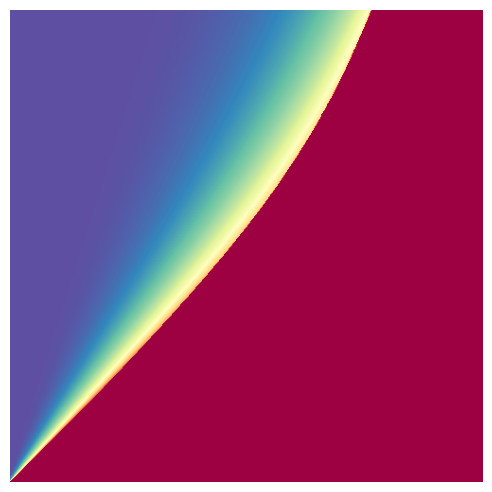

In [64]:
data = np.loadtxt("m_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)
plt.savefig("m_map.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)




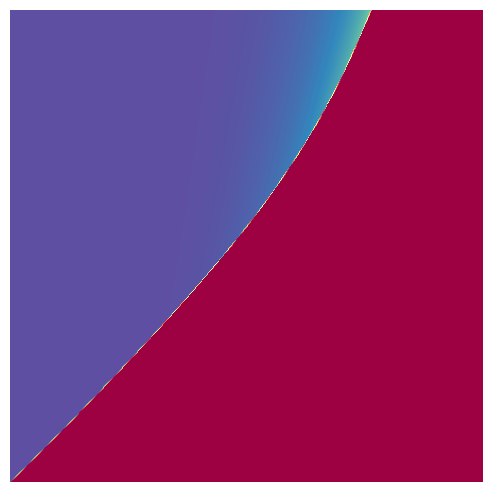

In [57]:
data2 = np.loadtxt("s_map.txt")
data2 = np.ma.masked_invalid(data2) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data2, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)
#plt.savefig("heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)
